# Neural Tangent Kernel

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
trainc=60

In [4]:
from pylab import *

In [5]:
rcParams['figure.figsize'] = 12,9
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
DEFAULT_COLORS = rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
import scipy.stats as st

In [7]:
from pytorch_utils.nb_figure import NBFigure

In [8]:
import imageio

In [9]:
def set_colors(count):
    colors = [get_cmap('inferno')(1. * i/count) for i in range(count)][::-1]
    plt.rc('axes', prop_cycle=cycler(color=colors))

In [10]:
from tqdm import tqdm_notebook

In [11]:
def reset_colors():
    plt.rc('axes', prop_cycle=cycler(color=DEFAULT_COLORS))    

In [12]:
from tqdm import tqdm

In [13]:
import torch
from torch import optim, nn
import copy
from utils import ZeroOutput, Scale, gd, simple_net, ntk, linear_gd

In [14]:
x = torch.linspace(-5, 5, 1000).unsqueeze(1)

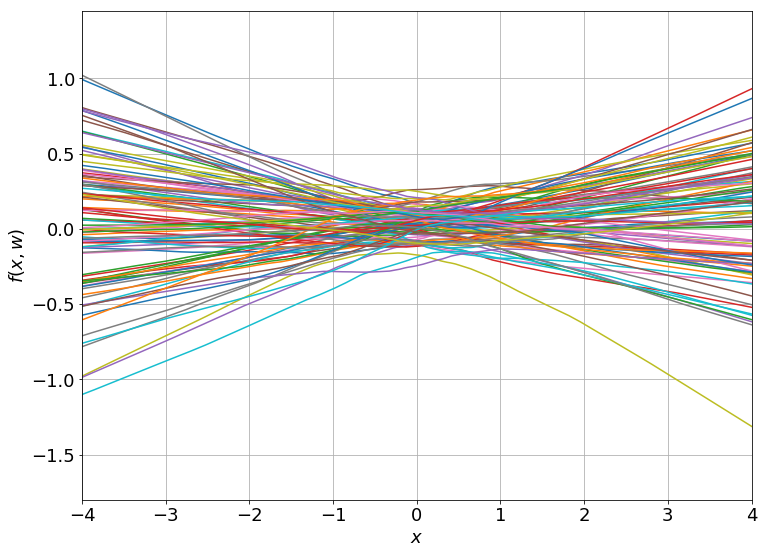

In [166]:
reset_colors()
m = 100
b = True
count = 100
for i in range(count):
    f = simple_net(width=m, bias=b, alpha=1, zero_output=False, hidden_layers=2)
    plot(x.detach(), f(x).detach())
xlabel("$x$")
ylabel("$f(x, w)$")
# ylim(-4, 4)
xlim(-4, 4)
savefig("net_funcs.png", bbox_inches='tight')
show()

In [16]:
# xin = torch.tensor([-1.0e-2, 1e-2]).unsqueeze(1)
xin = torch.tensor([-3, 0.5]).unsqueeze(1)
yin = torch.tensor([2, -1.0]).unsqueeze(1)

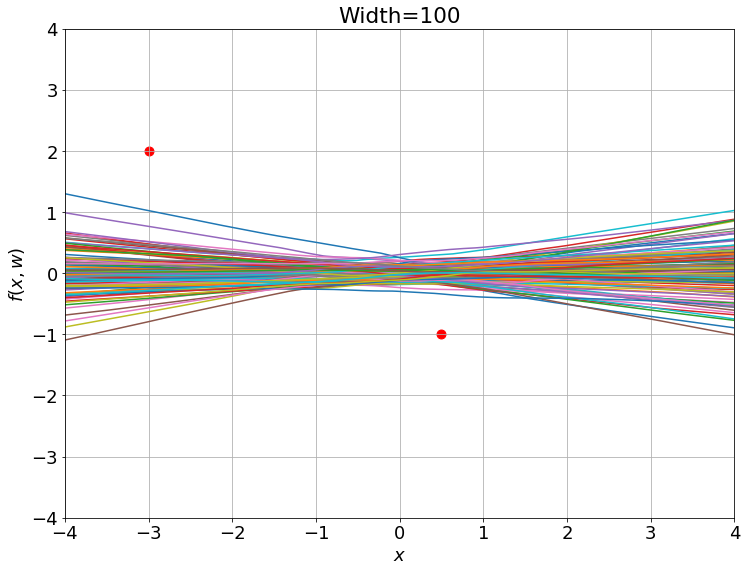

In [158]:
nbf = NBFigure('train_fig.png')
ax = nbf.getAxis()
nbf.set_xlim((-4, 4))
nbf.set_ylim((-4, 4))
nbf.display()
nbf.update()

In [159]:
m = 100
b = True
count = 100
depth = 2
alpha = 1
all_nets = [simple_net(width=m, bias=b, alpha=alpha, zero_output=False, hidden_layers=depth) for _ in range(count)]
tk0s = [ntk(net, xin)[1] for net in all_nets]
lines = []
for net in all_nets:
    l, = ax.plot(x.detach(), net(x).detach())
    lines.append(l)
ax.scatter(xin, yin, color='red', s=80)
ax.set_title(f"Width={m}")
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x, w)$")
nbf.update()

In [151]:
iters = 200
steps_per_iter = 5
lr = 1e-3
imgs = []
for i in tqdm_notebook(range(iters)):
    for line, net in zip(lines, all_nets):
        gd(net, xin, yin, alpha=alpha, iters=steps_per_iter, lr=lr, progress_bar=False)
        line.set_data(x.detach(), net(x).detach())
    nbf.update()
    imgs.append(imageio.imread('train_fig.png'))

KeyboardInterrupt: 

In [160]:
im0 = imageio.imread('train_fig.png')

In [163]:
imgs2 = [im0]*5+list(imgs)
imgs2 = array(imgs2)

In [164]:
imageio.mimwrite(f'gifs/train{trainc:03d}_alpha{alpha:.1e}_lr{lr:.1e}.gif', imgs2, duration=0.1)
trainc+=1

In [20]:
tk1s = [ntk(net, xin)[1] for net in all_nets]
changes = array([norm(t1-t0)/norm(t0) for t0,t1 in zip(tk0s, tk1s)])
print(changes.mean(), changes.std())

2.3085046 2.8668509


In [250]:
xs = {}
budges = {}
losses = {}

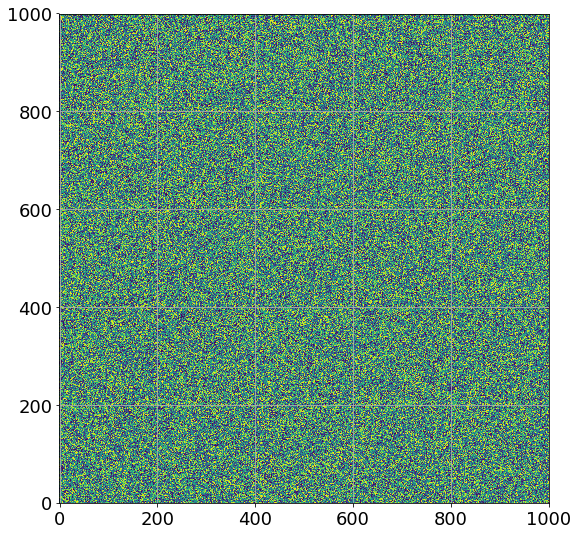

In [327]:
nbf = NBFigure('single_train.png')
ax = nbf.getAxis()
# nbf.set_xlim((-5, 5))
# nbf.set_ylim((-4, 4))
nbf.display()
nbf.update()

In [328]:
m = 1000
f = simple_net(width=m, bias=True, alpha=1, zero_output=False, hidden_layers=2)
A0, tk0 = ntk(f, xin)
weights0 = list(f.modules())[4].weight.detach().numpy().copy()
allw0 = nn.utils.parameters_to_vector(f.parameters()).detach().numpy().copy()
im = ax.imshow(weights0)
# l, = ax.plot(x.detach(), f(x).detach())
# ax.scatter(xin, yin, color='red', s=80)
nbf.update()
nbf2.update()

In [329]:
iters = 100
steps_per_iter = 1
lr = 1e-2
imgs = []
imgs2 = []
xvals = [0]
budgevals = [0]
lossvals = []
eps = 1e-10
t = tqdm_notebook(range(iters))
for i in t:
    ls = gd(f, xin, yin, alpha=1, iters=steps_per_iter, lr=lr, progress_bar=False)
    lossvals.extend(ls)
    t.set_postfix(loss=ls[-1])
#     l.set_data(x.detach(), f(x).detach())
    weights = list(f.modules())[4].weight.detach().numpy().copy()
    allw = nn.utils.parameters_to_vector(f.parameters()).detach().numpy().copy()
    budge = norm(allw-allw0)/norm(allw0)
    xvals.append((i+1)*steps_per_iter)
    budgevals.append(budge)
    im.set_data(weights)
    nbf.update()
    imgs.append(imageio.imread('single_train.png'))
    if ls[-1]<eps:
        break

In [333]:
imageio.mimwrite(f'gifs/weight_image/wim{trainc:03d}_width{m}.gif', imgs)
trainc += 1

In [330]:
xs[m] = xvals.copy()
budges[m] = budgevals.copy()
losses[m] = lossvals.copy()

In [331]:
norm(weights0-weights)/norm(weights0)

0.014936156

In [332]:
A1, tk1 = ntk(f, xin)
print(norm(tk1-tk0)/norm(tk0))

0.4808282


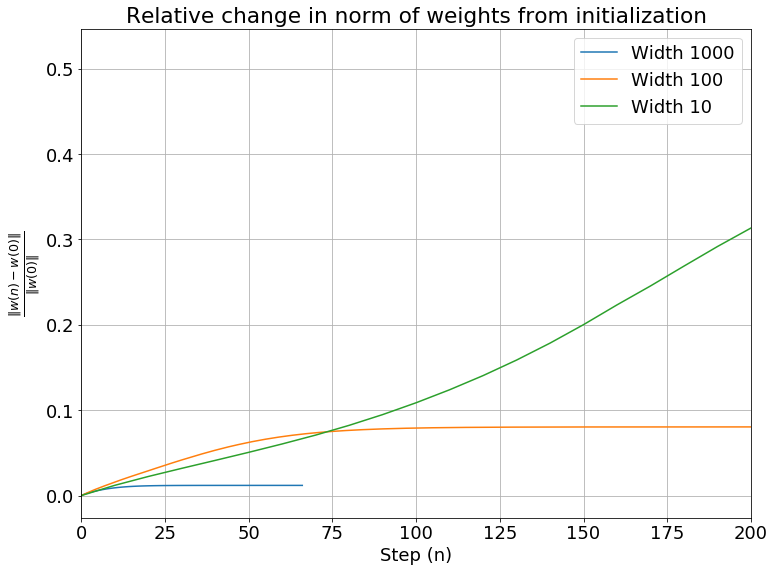

In [334]:
title(f"Relative change in norm of weights from initialization")
for m in xs.keys():
    plot(xs[m], budges[m], label=f"Width {m}")
xlabel("Step (n)")
ylabel(r"$\frac{\Vert w(n) -  w(0) \Vert}{\Vert w(0) \Vert}$")
legend()
xlim(0, 200)
# savefig(f"figs/weightchange_3widths.png", bbox_inches='tight')
show()

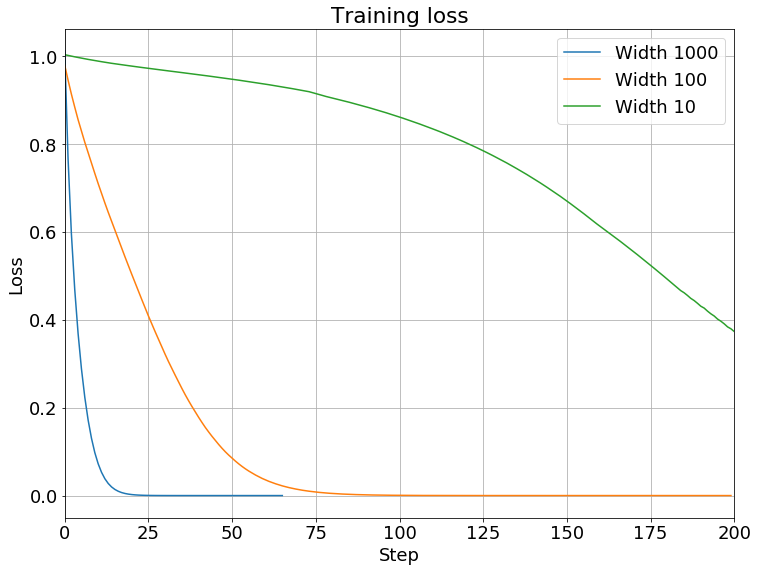

In [336]:
figure()
title(f"Training loss")
for m in xs.keys():
    plot(arange(len(losses[m])), losses[m], label=f"Width {m}")
xlabel("Step")
ylabel("Loss")
xlim(0, 200)
legend()
# savefig(f'figs/losses_3widths.png', bbox_inches='tight')
show()

In [167]:
m = 100
depth = 2
logalphas = linspace(-3, 3, 10)
trials = 1
alphas = 10**logalphas
b=True

set_colors(len(alphas))

dels = []
out = ""
for alpha in tqdm_notebook(alphas):
    del_dh = 0
    for k in range(trials):
        f = simple_net(width=m, bias=b, alpha=alpha, zero_output=True, hidden_layers=depth)
        A0, tk0 = ntk(f, xin)
        gd(f, xin, yin, alpha=alpha, iters=4000, lr=1e-3, progress_bar=False)
        A1, tk1 = ntk(f, xin)
        y = f(x)
        del_dh += norm(tk1-tk0)/norm(tk0)
    dels.append(del_dh/trials)
    out += f"{alpha:.4e}\t{del_dh/trials}\n"
    plot(x.detach(), y.detach())

print("alpha\t\trelative change in tk norm")
print(out)
sm = cm.ScalarMappable(cmap=get_cmap('inferno_r'), norm=Normalize(vmin=logalphas[0], vmax=logalphas[-1]))
sm._A=[]
colorbar(sm, label='logalpha')

scatter(xin, yin, color='red', s=80)
show()

KeyboardInterrupt: 

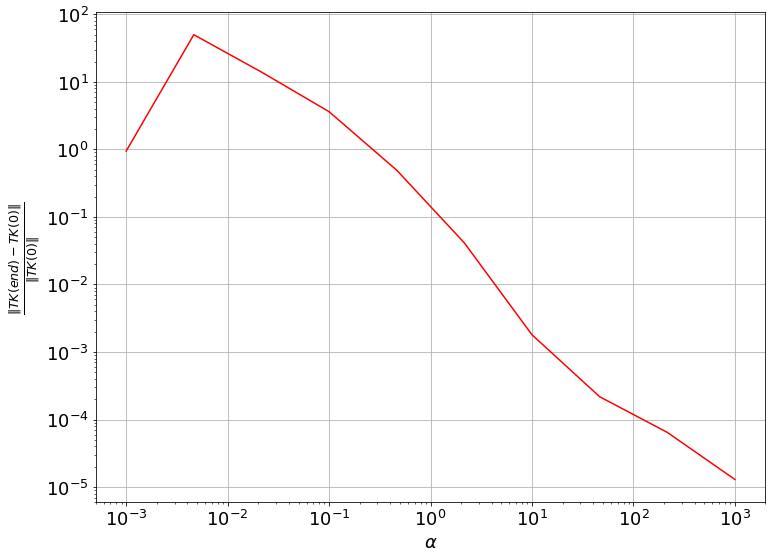

In [29]:
loglog()
plot(alphas, dels, color='red')
xlabel(r"$\alpha$")
ylabel(r"$\frac{\Vert TK(end) - TK(0) \Vert}{\Vert TK(0) \Vert}$")
show()

In [30]:
st.linregress(log(alphas), log(dels))[0]

-1.090981262845702

In [462]:
b=True
# m=1000
ms = 10**linspace(0, 4, 5)
ms = ms.astype(np.int64)
tks = []
for m in tqdm_notebook(ms):
    f = simple_net(m, zero_output=False)
    # f = ZeroOutput(f)

    A, tk = ntk(f, x)
    tk/=m
    tks.append(tk)
A.shape

torch.Size([1000, 30001])

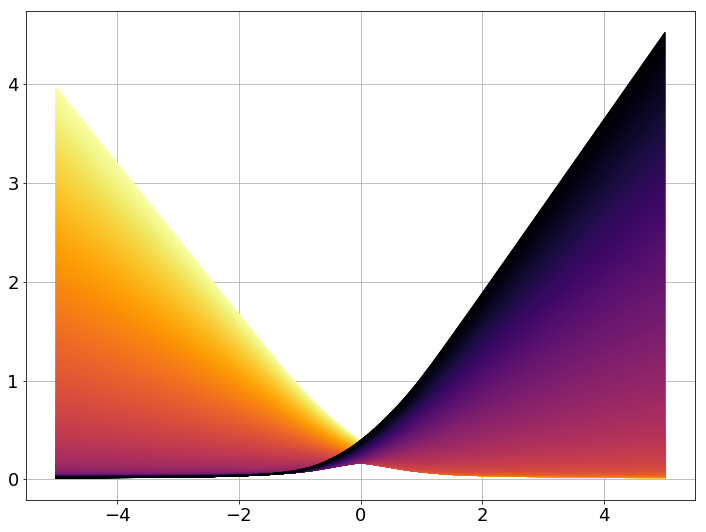

In [449]:
set_colors(A.shape[0])
# plot(x, tk[500], color='red')
plot(x, tk)
show()

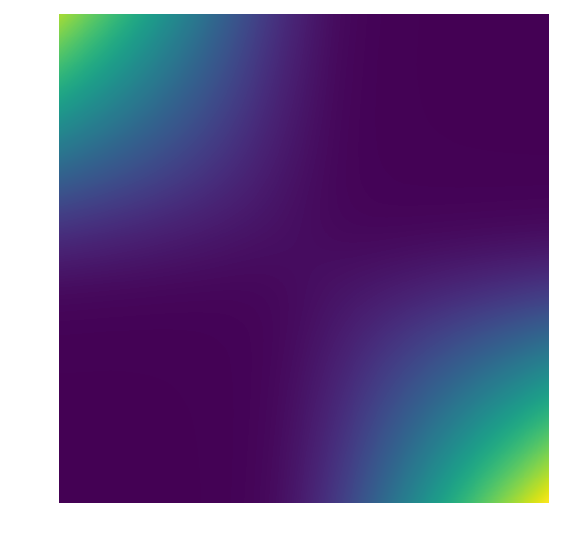

In [450]:
axis('off')
imshow(tk)

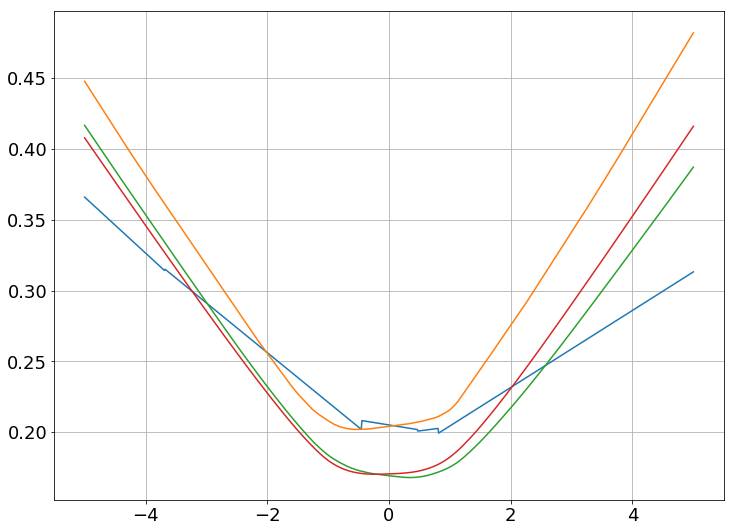

In [464]:
# loglog()
reset_colors()
for tk in tks[1:]:
    plot(x, tk[len(tk)//2])

---

In [167]:
import os, json

In [168]:
def get_scaledtks(run_dir):
    with open(f'{run_dir}/config.json') as f:
        cfg = json.loads(f.read())
    alpha = cfg['alpha']
    print(f"alpha={alpha}")
    xin = torch.tensor(cfg['xdata']).float().unsqueeze(1)
    
    end = '.model'
    mods = [s for s in os.listdir(run_dir) if s[-len(end):]==end]
    mods = sorted(mods)
    tks = []
    ys = []
    models = []
    for mod in mods:
    #     print(std)
        try:
            model = torch.load(f"{run_dir}/{mod}")
        except EOFError:
            break
        A, tk = ntk(model, xin)
        tks.append(tk)
        ys.append(model(xin))
        models.append(model)
    print(A.shape)
    scaled_tks = [t/(alpha**2) for t in tks]
    ynp = array([y_.detach().numpy() for y_ in ys])
    ynp = ynp.reshape(-1, 2)
    return models, ynp, scaled_tks, alpha

In [169]:
def kernel_to_angle(A):
    l, Q = eigh(A)
    q1 = Q[0]
    ang = arctan2(q1[1], q1[0]) * 180/pi
    return 1/l[0], 1/l[1], ang

In [170]:
center = (3, -1)

In [171]:
def update_ellipse(e, w, h, ang):
    e.width = w
    e.height = h
    e.angle = ang

In [172]:
from matplotlib.patches import Ellipse

In [178]:
first = 1
runs = arange(first, first+7)
ys = []
stks = []
alphas = []
models = []
for run in runs:
    run_dir = f"runs/{run}"
    mod, y, tk, alpha = get_scaledtks(run_dir)
    ys.append(y)
    stks.append(tk)
    alphas.append(alpha)
    models.append(mod)

alpha=0.05
torch.Size([2, 10401])
alpha=0.1
torch.Size([2, 10401])
alpha=0.5
torch.Size([2, 10401])
alpha=1.0
torch.Size([2, 10401])
alpha=5.0
torch.Size([2, 10401])
alpha=10.0
torch.Size([2, 10401])
alpha=50.0
torch.Size([2, 10401])


In [179]:
xin2 = [-2, 0.5]
yin2 = [3, -1.0]

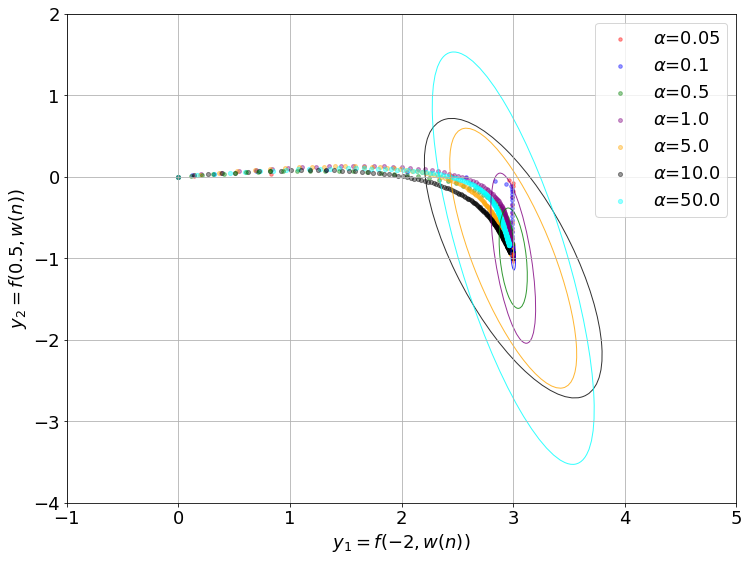

In [182]:
nbf = NBFigure('testanim.png')
ax = nbf.getAxis()
h = 1
nbf.set_xlim((-1, 5))
nbf.set_ylim((-4, 2))
nbf.display()
nbf.update()

In [183]:
imgs = []
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'cyan']
c = 30
length = 200
ellipses = []
for j in range(len(alphas)):
    w, h, ang = kernel_to_angle(stks[j][0].numpy())
    e = Ellipse(center, w*c, h*c, ang, fc='None', ec=colors[j], alpha=0.8, lw=1)
    ellipses.append(e)
    ax.add_artist(e)
nbf.update()
ax.set_xlabel(f"$y_1 = f({xin2[0]}, w(n))$")
ax.set_ylabel(f"$y_2 = f({xin2[1]}, w(n))$")
for i in tqdm_notebook(arange(length)):
    for j in range(len(alphas)):
        if i >= len(stks[j]):continue
        w, h, ang = kernel_to_angle(stks[j][i].numpy())
        update_ellipse(ellipses[j], w*c, h*c, ang)
        ax.scatter(ys[j][i, 0], ys[j][i, 1], s=12+j, alpha=0.4, color=colors[j], label=f"$\\alpha$={alphas[j]}")
    if i==0:
        ax.legend()
    nbf.update()
    imgs.append(imageio.imread('testanim.png'))

In [184]:
imageio.mimwrite(f'gifs/ellipses/ellipses{trainc}.gif', imgs, duration=0.1)
trainc+=1

In [77]:
def f(w, x, alpha=1, w00=0.4):
    return alpha*(w*x + w**2*x + torch.sin(torch.exp(0.1*w)))*(w-w00)

In [79]:
ws = torch.linspace(-3,3, 3000)
x = 1.5
y = 3
w0 = torch.tensor(0.4, requires_grad=True)

In [89]:
alphas = 10**linspace(0, 10, 300)
l1 = None
l2 = None
imgs2 = []
xl = 1.5
yl = 8
ax2.set_ylabel(f"Loss for x={x}, y={y}")
for alpha in tqdm_notebook(alphas):
    h0 = f(w0, x, alpha=alpha)
    assert h0 == 0
    w0.grad = torch.tensor(0.0)
    h0.backward()
    dw = w0.grad
    ax2.set_title(f"$\\alpha$={alpha:.3f}")
    if l1 != None:
        l1.set_data(ws, (1/(alpha*alpha))*((y - (f(ws, x, alpha=alpha)))**2).detach())
        l2.set_data(ws, (1/(alpha*alpha))*((y - (h0+dw*(ws-w0)))**2).detach())
    else:
        l1, = ax2.plot(ws, 1/alpha**2*((y - (f(ws, x, alpha=alpha)))**2).detach(), color='blue', label='Actual loss')
        l2, = ax2.plot(ws, 1/alpha**2*((y - (h0+dw*(ws-w0)))**2).detach(), color='red', label='Linearized loss')
        ax2.legend(loc='upper right')
#     print(l1, l2)
    nbf2.set_xlim((-xl+w0.item(), xl+w0.item()))
    nbf2.set_ylim((max(-0.1, -yl/3), yl))
    xl*=0.95
    yl*=0.91
    nbf2.update()
    imgs2.append(imageio.imread('test2.png'))

SystemError: <built-in method write of _io.BufferedWriter object at 0x1a25aeaa98> returned a result with an error set

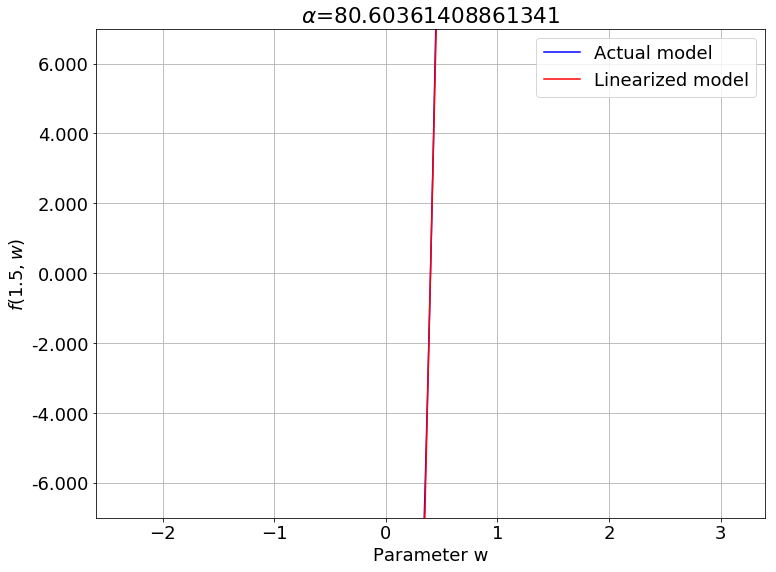

In [101]:
nbf2 = NBFigure('test2.png')
ax2 = nbf2.getAxis()
nbf2.set_xlim((w0.item()-0.5, w0.item()+0.5))
nbf2.set_ylim((-0.1, 1))
ax2.set_xlabel("Parameter w")
ax2.set_ylabel("Loss")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
nbf2.display()
nbf2.update()

In [102]:
alphas = 10**linspace(0, 10, 300)
l1 = None
l2 = None
imgs2 = []
ax2.set_ylabel(f"$f({x}, w)$")
# nbf2.set_xlim((-0.2, 0.2))
xl = 3
yl = 7
for alpha in tqdm_notebook(alphas):
    h0 = f(w0, x, alpha=alpha)
    assert h0 == 0
    w0.grad = torch.tensor(0.0)
    h0.backward()
    dw = w0.grad
    ax2.set_title(f"$\\alpha$={alpha}")
    if l1 != None:
        l1.set_data(ws, f(ws, x, alpha=alpha).detach())
        l2.set_data(ws, (h0+dw*(ws-w0)).detach())
    else:
        l1, = ax2.plot(ws, f(ws, x, alpha=alpha).detach(), color='blue', label='Actual model')
        l2, = ax2.plot(ws, (h0+dw*(ws-w0)).detach(), color='red', label='Linearized model')
        ax2.legend(loc='upper right')
#     print(l1, l2)
    nbf2.set_xlim((-xl+w0.item(), xl+w0.item()))
    nbf2.set_ylim((-yl, yl))
#     xl*=0.85
#     yl*=0.91
    nbf2.update()
    imgs2.append(imageio.imread('test2.png'))

SystemError: <built-in method write of _io.BufferedWriter object at 0x1a28dc2a98> returned a result with an error set

In [103]:
imageio.mimwrite(f'gifs/funcs{trainc:03d}.gif', imgs2, duration=0.1)
trainc+=1

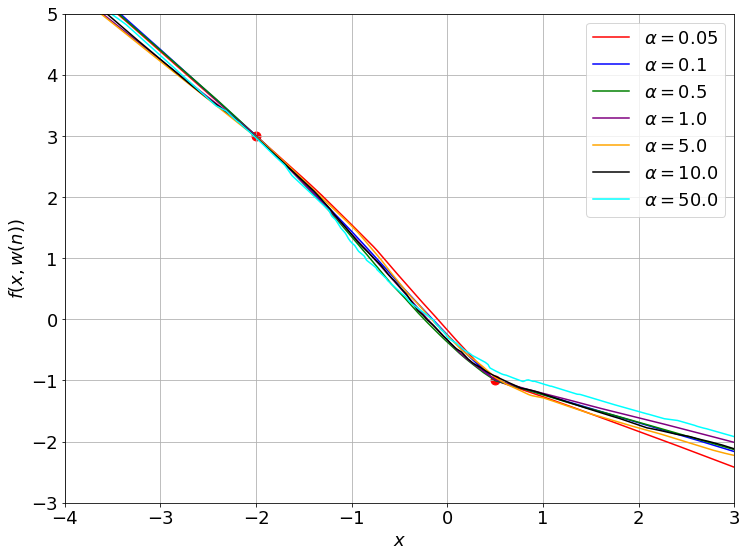

In [185]:
nbf = NBFigure('train_fig2.png')
ax = nbf.getAxis()
nbf.set_xlim((-4, 3))
nbf.set_ylim((-3, 5))
nbf.display()
nbf.update()

In [186]:
ax.scatter(xin2, yin2, color='red', s=80)
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x, w(n))$")
nbf.update()

In [187]:
x = torch.linspace(-5, 5, 1000).unsqueeze(1)
imgs = []
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'cyan']
lines = []
for j in range(len(alphas)):
    l, = ax.plot(x.detach(), models[j][0](x).detach(), label=f'$\\alpha={alphas[j]}$', color=colors[j])
    lines.append(l)
nbf.update()
# ax.set_xlabel(f"$y_1 = f({xin[0].item()}, w(n))$")
# ax.set_ylabel(f"$y_2 = f({xin[1].item()}, w(n))$")
for i in tqdm_notebook(arange(length)):
    for j in range(len(alphas)):
        if i >= len(models[j]):continue
        lines[j].set_data(x.detach(), models[j][i](x).detach())
    if i==0:
        ax.legend()
    nbf.update()
    imgs.append(imageio.imread('train_fig2.png'))

In [188]:
imageio.mimwrite(f'gifs/train_funcs{trainc:03d}.gif', imgs, duration=0.1)
trainc+=1

In [31]:
colors

['red', 'blue', 'green', 'purple', 'orange', 'black', 'cyan']

(-1, 1)

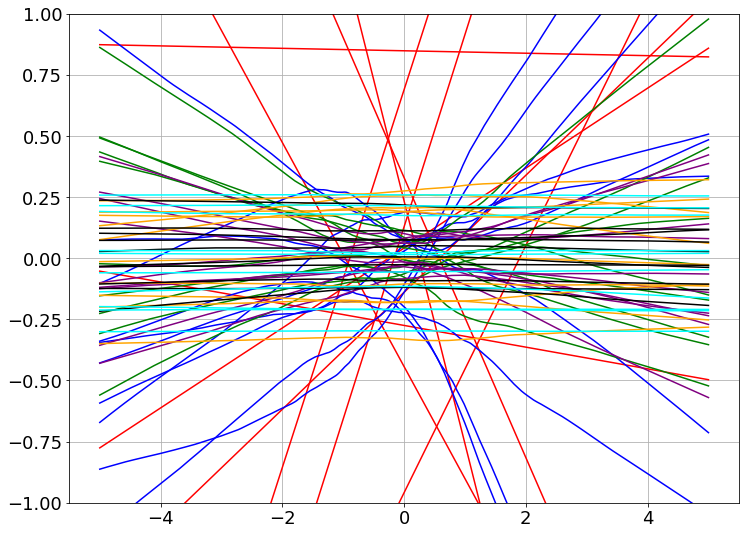

In [44]:
count = 10
ms = [1, 10000, 100, 1000,10, 100,10, 10]
x = torch.linspace(-5, 5, 1000).unsqueeze(1)
zs = [x.clone() for _ in range(count)]
i=0
for mold, m in zip(ms[:-1], ms[1:]):
    for c in range(count):
        if i!=0:
            zs[c] = nn.ReLU()(zs[c])
        zs[c] = nn.Linear(mold, m)(zs[c])
#         print(zs[c].shape)
        plot(x.detach(), zs[c][:,0].detach(), color=colors[i], alpha=1)
    i+=1
ylim(-1, 1)

In [137]:
ff = simple_net(10, hidden_layers=2, zero_output=False)

ff(torch.tensor([[1.0]])).backward()

p = nn.utils.parameters_to_vector(ff.parameters())

norm(p.detach())

3.4301546